# Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.   
**Постройте модель с предельно большим значением F1-меры.** Чтобы сдать проект успешно, нужно **довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно. Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.**

## 1. Загрузите и подготовьте данные. Поясните порядок действий.

In [1]:
import pandas as pd
from joblib import dump
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve 
import matplotlib.pyplot as plt
from time import sleep
from tqdm import tqdm
import sys
from sklearn.model_selection import GridSearchCV

Подключил библиотеки.

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

Загрузил файл с базой данных и сохранил ее в переменную data

In [3]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Просмотрел первые 10 значений в таблице.

In [4]:
print(data.shape)

(10000, 14)


Просмотрел информацию о количестве наблюдений и признаков, вижу, что в таблице 10000 строк и 14 столбцов.

In [5]:
print(data.columns)

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')


Вывел названия столбцов.

In [6]:
data.columns = data.columns.str.lower()

Переименовал столбцы, привел все названия к нижнему регистру.

In [7]:
data.duplicated().sum()

0

Проверил количество явных дубликатов.

In [8]:
data.isna().sum()

rownumber            0
customerid           0
surname              0
creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64

Проверил количество пропущенных значений, обнаружил 909 пропусков в столбце tenure.

In [9]:
data['tenure'] = data['tenure'].fillna(value='0')

Заменил все пропущенные значения в **tenure** на 0.

In [10]:
data.isna().sum()

rownumber          0
customerid         0
surname            0
creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

Повторно проверил и убедился, что теперь Nan отсутствуют.

In [11]:
data.nunique()

rownumber          10000
customerid         10000
surname             2932
creditscore          460
geography              3
gender                 2
age                   70
tenure                12
balance             6382
numofproducts          4
hascrcard              2
isactivemember         2
estimatedsalary     9999
exited                 2
dtype: int64

Количество уникальных значений.

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           10000 non-null  object 
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 1.1+ MB


Просмотрел общую информацию по датафрейму и всем признакам.

## Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.

In [13]:
data = data.drop(columns = ['rownumber', 'customerid', 'surname'],axis = 1)

Удалил столбцы с не нужными данными из датафрэйма.

In [14]:
data_ohe = pd.get_dummies(data, drop_first=True)

Применил прямое кодирование ко всему датафрейму.

In [15]:
print(data_ohe.columns)

Index(['creditscore', 'age', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited', 'geography_Germany',
       'geography_Spain', 'gender_Male', 'tenure_1.0', 'tenure_2.0',
       'tenure_3.0', 'tenure_4.0', 'tenure_5.0', 'tenure_6.0', 'tenure_7.0',
       'tenure_8.0', 'tenure_9.0', 'tenure_10.0', 'tenure_0'],
      dtype='object')


Проверил названия столбцов после преобразования.

0    0.7963
1    0.2037
Name: exited, dtype: float64


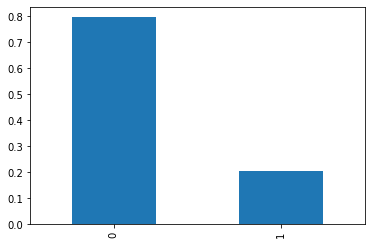

In [16]:
exited = data_ohe['exited'].value_counts(normalize=True)
print(exited)
exited.plot(kind='bar');

Проверил какое количество пользователей ушли:  
**Остались** - 0.8%;    
**Ушли** - 0.2%.

In [17]:
features = data_ohe.drop(['exited'], axis=1) # выделил признак
target = data_ohe['exited'] # выделил целевой признак

Выделил признаки.

In [18]:
features_train, features_valid, target_train, target_valid = train_test_split\
                    (features, target, test_size=0.4, random_state=54321, stratify=target)

Выделил 40% данных для валидационной выборки.

In [19]:
features_train, features_test, target_train, target_test = train_test_split\
                    (features_train, target_train, test_size=0.2, random_state=54321, stratify=target_train)

Выделил 20% данных для тестовой выборки.

In [20]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(4800, 21)
(4000, 21)
(1200, 21)


Проверил количество наблюдений для каждой выборки.

In [21]:
model = RandomForestClassifier(random_state=123456) # исследую модель случайный лес
model.fit(features_train, target_train) # обучил модель на обучающей выборке
predictions_valid = model.predict(features_valid) # нашел предсказания на валидационной выборке
print("F1-мера:", f1_score(target_valid, predictions_valid))

F1-мера: 0.5813040062843676


0    0.8855
1    0.1145
dtype: float64


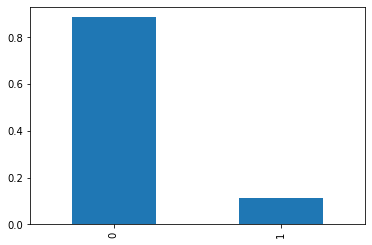

In [22]:
predictions_valid = pd.Series(model.predict(features_valid))
class_frequency = predictions_valid.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

Проверил предсказание на модели решающее дерево:  

**Остались** - 0.89%;  
**Ушли** - 0.11%.

In [23]:
model = LogisticRegression(random_state=123456) # исследую модель логистическая регрессия
model.fit(features_train, target_train) # обучил модель на обучающей выборке
predictions_valid = model.predict(features_valid) # нашел предсказания на валидационной выборке
print("F1-мера:", f1_score(target_valid, predictions_valid))

F1-мера: 0.12358393408856848


Исследую модель Логистическая регрессия

In [24]:
model = DecisionTreeClassifier(random_state=123456) # исследую модель дерево решений
model.fit(features_train, target_train) # обучил модель на обучающей выборке
predictions_valid = model.predict(features_valid) # нашел предсказания на валидационной выборке
print("F1-мера:", f1_score(target_valid, predictions_valid))

F1-мера: 0.49610545236668663


Исследую модель Дерево решений

In [25]:
model = RandomForestClassifier(random_state=123456) # исследую модель случайный лес
model.fit(features_train, target_train) # обучил модель на обучающей выборке
predictions_valid = model.predict(features_valid) # нашел предсказания на валидационной выборке
print("F1-мера:", f1_score(target_valid, predictions_valid))

F1-мера: 0.5813040062843676


Исследую модель Случайный лес

In [26]:
values = confusion_matrix(target_valid, predictions_valid) 
print(values)
values = range(3)
with tqdm(total=len(values), file=sys.stdout) as pbar:
    for i in values:
        pbar.set_description('processed: %d' % (1 + i))
        pbar.update(1)
        sleep(1)

[[3097   88]
 [ 445  370]]
processed: 3: 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]


Рассчитал матрицу ошибок

In [27]:
precision = precision_score(target_valid, predictions_valid)
recall = recall_score(target_valid, predictions_valid)
f1 = 2 * precision * recall / (precision + recall)

print("Полнота:", recall)
print("Точность:", precision)
print("F1-мера:", f1)

Полнота: 0.4539877300613497
Точность: 0.8078602620087336
F1-мера: 0.5813040062843676


**Вывод** - Проведя анализ данных, мы видим, что данные не сбалансированы:  
[3097 | 88]  
 [ 445 | 370]

Значение **recall** - ближе к нулю, модель надо перепроверить и починить.  
Значение **precision** - модель считается хорошей, если точность близка к единице.  
Значение **F1-меры** - когда полнота или точность близки к нулю, то к 0 приближается и само среднее гармоническое.  

## Борьба с дисбалансом.

In [28]:
best_model = None
best_result = 0
for depth in range(490, 500):
    model = RandomForestClassifier(n_estimators=depth, random_state=123) # < создайте модель, указав max_depth=depth >
    model.fit(features_train, target_train)# < обучите модель >
    predictions_valid = model.predict(features_valid)# < найдите предсказания на валидационной выборке >
    result = model.score(features_valid, target_valid)
    
    precision = precision_score(target_valid, predictions_valid)
    recall = recall_score(target_valid, predictions_valid)
    f1 = 2 * precision * recall / (precision + recall)
    
    if result > best_result:
        best_model = model # сохраните наилучшую модель
        best_result = result #  сохраните наилучшее значение метрики accuracy на валидационных данных
    print("max_depth =", depth, ": ", f1, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid)) 

max_depth = 490 :  0.594887683965918 : 0.86925
max_depth = 491 :  0.5944272445820433 : 0.869
max_depth = 492 :  0.594887683965918 : 0.86925
max_depth = 493 :  0.5939675174013921 : 0.86875
max_depth = 494 :  0.5944272445820433 : 0.869
max_depth = 495 :  0.5944272445820433 : 0.869
max_depth = 496 :  0.5953488372093023 : 0.8695
max_depth = 497 :  0.5953488372093023 : 0.8695
max_depth = 498 :  0.5953488372093023 : 0.8695
max_depth = 499 :  0.5944272445820433 : 0.869


Добавил функция для расчета максильного значения F1-меры для RandomForestClassifier.

In [29]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced') # исследую модель лог.регресс
model.fit(features_train, target_train) # обучил модель на обучающей выборке
predictions_valid = model.predict(features_valid) # нашел предсказания на валидационной выборке
print("F1-мера:", f1_score(target_valid, predictions_valid))

F1-мера: 0.44097639055622245


Переобучил модель логистической регрессии с равнозначными классами. Сделал веса классов сбалансированными.  
Значение **F1-меры** увеличилось с 0.1 до 0.44.

In [48]:
model = DecisionTreeClassifier(max_depth=5, random_state=123456, class_weight='balanced') # исследую модель дерево решений
model.fit(features_train, target_train) # обучил модель на обучающей выборке
predictions_valid = model.predict(features_valid) # нашел предсказания на валидационной выборке
print("F1-мера:", f1_score(target_valid, predictions_valid))

F1-мера: 0.5753931544865866


Переобучил модель дереву решений.  
Значение **F1-меры** увеличилось с 0.44 до 0.57.  

In [31]:
model = RandomForestClassifier(n_estimators=495, random_state=123) # исследую модель случайный лес
model.fit(features_train, target_train) # обучил модель на обучающей выборке
predictions_valid = model.predict(features_valid) # нашел предсказания на валидационной выборке
print("F1-мера:", f1_score(target_valid, predictions_valid))

F1-мера: 0.5944272445820433


Переобучил модель распределенное дерево.    
Значение **F1-меры** увеличилось до 0.59.

In [49]:
numeric = ['creditscore', 'age', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Стандартизировал признаки.

In [50]:
model = RandomForestClassifier(n_estimators=495, random_state=123) # исследую модель случайный лес
model.fit(features_train, target_train) # обучил модель на обучающей выборке
predictions_valid = model.predict(features_valid) # нашел предсказания на валидационной выборке
print("F1-мера:", f1_score(target_valid, predictions_valid))

F1-мера: 0.5955143078112916


Переобучил модель случайный лес.  
Значение F1-меры увеличилось незначительно с 0.561 до 0.595

In [51]:
model = DecisionTreeClassifier(max_depth=10, random_state=123456) # исследую модель дерево решений7
model.fit(features_valid, target_valid) # обучил модель на валидационной выборке
predictions_train = model.predict(features_train) # нашел предсказания на обучающей выборке
print("F1-мера:", f1_score(target_train, predictions_train))

F1-мера: 0.5357548240635642


Переобучил модель дереву решений.  
Значение F1-меры уменьшилось.

In [63]:
def upsample(features, target, repeat):
    features_zeros = features[target_train == 0]
    features_ones = features[target_train == 1]
    target_zeros = target[target_train == 0]
    target_ones = target[target_train == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle (features_upsampled, target_upsampled, random_state=123456)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 2)

model = RandomForestClassifier(n_estimators=495, random_state=123)
model.fit(features_upsampled, target_upsampled)

predicted_valid = model.predict(features_valid)
print("F1-мера:", f1_score(target_valid, predicted_valid))

F1-мера: 0.6065340909090908


Увеличил выборки, значение F1-меры увеличилось с 0.53 до 0.6.

0    0.83875
1    0.16125
dtype: float64


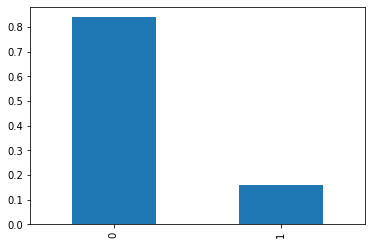

In [59]:
predictions_valid = pd.Series(model.predict(features_valid))
class_frequency = predictions_valid.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

Проверил предсказание на модели решающее дерево:  

**Остались** - 0.84%;  
**Ушли** - 0.16%.

In [60]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Вероятность класса 1',probabilities_one_valid[:5])
print()
for threshold in np.arange(0, 0.3, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(threshold, precision, recall))    

Вероятность класса 1 [0.08080808 0.16969697 0.07474747 0.01414141 0.71919192]

Порог = 0.00 | Точность = 0.205, Полнота = 1.000
Порог = 0.02 | Точность = 0.222, Полнота = 0.996
Порог = 0.04 | Точность = 0.241, Полнота = 0.985
Порог = 0.06 | Точность = 0.262, Полнота = 0.968
Порог = 0.08 | Точность = 0.283, Полнота = 0.948
Порог = 0.10 | Точность = 0.302, Полнота = 0.929
Порог = 0.12 | Точность = 0.318, Полнота = 0.910
Порог = 0.14 | Точность = 0.337, Полнота = 0.883
Порог = 0.16 | Точность = 0.356, Полнота = 0.869
Порог = 0.18 | Точность = 0.374, Полнота = 0.845
Порог = 0.20 | Точность = 0.394, Полнота = 0.831
Порог = 0.22 | Точность = 0.407, Полнота = 0.813
Порог = 0.24 | Точность = 0.424, Полнота = 0.796
Порог = 0.26 | Точность = 0.441, Полнота = 0.767
Порог = 0.28 | Точность = 0.465, Полнота = 0.751


Вероятность не большая, при пороге 0 полнота равна 1 - все ответы положительные.  
При увеличении порога полнота падает.

AUC-ROC 0.848096233302193


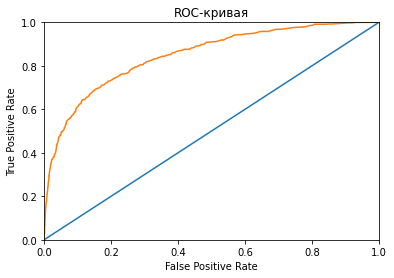

In [61]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)  # < напишите код здесь >
auc_roc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])# < напишите код здесь >
print('AUC-ROC', auc_roc)
plt.figure()
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()    

Доля TPR больше чем FPR, качество модели лучше. Метрика AUC-ROC равно 0.85.

**Вывод** - В данном модуле я проверил несколько разных методов борьбы с несбалансированностью классов, некоторые методы показали незначительный результат, некоторые дали заметный положительный результат.  
В результате, на модели RandomForestClassifier, после перемешивания данных удалось достигнуть величины F1-меры равной 0.60.

## Тестирование модели.

In [64]:
predicted_test = model.predict(features_test)
print("F1-мера:", f1_score(target_test, predicted_test))

F1-мера: 0.591016548463357


На тестовой выборке значение F1-меры 0.59.

In [65]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, model.predict_proba(features_test)[:, 1])# < напишите код здесь >
print('AUC-ROC', auc_roc)

AUC-ROC 0.8614702654503051


На тестовой выборке значение AUC-ROC 0.86.

## Вывод

Перед нами стояла задача построить модель с предельно большим значением F1-меры.  
- Мы загрузили исходный датасет, провели минимальный анализ данных на наличие дубликатов, пропущенных значений и т.д.
- Выполнили разделение исходных данных на обучающую, валидационную и тестовую выборку;
- Далее выделили признаки для моделей и обучили модели.  
- Выбрали модель с самым высоким уровнем F-меры на обучающей выборке и провели сравнение с тестовой выборкой.
- Сравнили значения AUC-ROC для модели на обучающей выборке и на тестовой выборке.

Модель случайны лес, показала лучшее значение F1-меры равное 0.6., т.е. 6 из 10 правильных ответов. Модель нам подходит.